## Image Registration: performance checks

This notebook demonstrates use of [Scikit-rt](https://github.com/scikit-rt/scikit-rt) for performing image registration using [Elastix](https://elastix.lumc.nl), and for checking what the registration has done.

### 1. Initial setup

To run this notebook, it is necessary in the code cell below to set:
- the path to the Elastix directory, with sub-directories `bin` and `lib`containing the Elastix execuables and libraries respectively;
- the path to a writeable directory, to be used for registration output.

To allow image rendering on GitHub, this notebook has been run with user-interface elements ([Jupyter widgets](https://ipywidgets.readthedocs.io/en/latest/)) omitted.  To enable interactive controls, in the first code cell below set:
```
no_ui = False
```

In [1]:
# Import required modules.
from pathlib import Path

import matplotlib.pyplot as plt

from skrt.patient import Patient
from skrt.simulation import SyntheticImage
from skrt.registration import Registration, get_default_pfiles_dir, set_elastix_dir

# Set path to elastix installation.
set_elastix_dir('~/sw/elastix-5.0.1-mac')
# Set path to directory to be used for registration output.
outdir = 'registration_results/synthetic'
# Define whether or not to display user interface, allowing interactive view adjustment.
no_ui = True

### 2. Display options

Scikit-rt provides a large number of options for customising image display, both directly (see documentation for [better_viewer package](https://scikit-rt.github.io/scikit-rt/skrt.better_viewer.html#module-skrt.better_viewer), and indirectly, via Matplotlib [plot options](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) and [runtime configuration](https://matplotlib.org/stable/tutorials/introductory/customizing.html).  Options used for all plots in this notebook are set in the code cell below.  Additional options are set in individual display commands.

In [2]:
# Set Matplotlib runtime configuration.
# For details of Matplotlib configuration, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Sizes are in points.

# For axes, set spacing (pad) and size of label and title
plt.rc("axes", labelpad=0, labelsize=25, titlepad=17, titlesize=25)

# Set default text charactieristics.
# Possible weight values are:
# 100, 200, 300, 400 / "normal", 500, 600, 700 / "bold", 800, 900.
plt.rc("font", family="serif", serif=["Times"], size=20, weight=400)

# Set default font size for legends.
plt.rc("legend", fontsize=16)

# Set mathematics typeface when using matplotlib's built-in fonts.
plt.rc("mathtext", fontset="dejavuserif")

# Use TeX/LaTeX for typesetting.  (This requires working TeX/LaTeX installation.)
plt.rc("text", usetex=True)

# For ticks, set label size and direction ("in", "out", "inout").
plt.rc(("xtick", "ytick"), labelsize=25, direction="out")

# For major and minor ticks, set size and width.
# For major ticks, set spacing (pad) of label.
plt.rc(("xtick.major"), pad=3)
plt.rc(("xtick.major", "ytick.major"), size=9, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0)
plt.rc(("ytick.major"), pad=2)

# Create dictionary of BetterViewer image-display options.
options = {
    # Show major ticks at specified interval (axis units).
    "major_ticks": 25,
    # Show minor ticks for specified number of intervals between major ticks.
    "minor_ticks": 5,
    # Indicate whether axis units should be mm or numbers of voxels.
    "scale_in_mm" : True,
    # Indicate whether ticks should be shown on all sides.
    "ticks_all_sides": True,
    # Define whether or not to display user interface, for interactive viewing.
    "no_ui": no_ui,
    # Colour map for images.  For pre-defined colour maps, see:
    # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    "cmap": "binary",
    # Define options for colour bars.  For possibilities, see:
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar
    "clb_kwargs": {"pad":0.1},
    # Define options for colour-bar labels.  For possibilities, see:
    # https://matplotlib.org/stable/api/colorbar_api.html#matplotlib.colorbar.Colorbar.set_label
    "clb_label_kwargs": {"labelpad": 5},
}

### 3. Synthetic images for registration

Example synthetic images for registration are defined in the code cell below.  These may be replaced by other synthetic images (see some possibilities in: [simulation module](https://scikit-rt.github.io/scikit-rt/skrt.simulation.html)) or by [DICOM](https://www.dicomstandard.org/) or [NIfTI](https://nifti.nimh.nih.gov/) image data loaded as [Image](https://scikit-rt.github.io/scikit-rt/skrt.image.html#skrt.image.Image) objects.

In [3]:
# Fixed image for registration, featuring sphere of radius 30 mm.
fixed = SyntheticImage(shape=(101, 101, 101), origin=(-50, -50, -50))
fixed.add_sphere(radius=30, name="sphere", centre=(0, 0, 0), intensity=100)

# Moving image for registration, featuring cube of side length 40 mm.
moving = SyntheticImage(shape=(101, 101, 101), origin=(-50, -50, -50))
dx, dy, dz = (4, -4, 2)
moving.add_cube(side_length=40, name="cube", centre=(dx, dy, dz), intensity=100)

### 3. Define and run registration.

The registration is run as a sequence of steps.  For details of the parameters used in defining the registration steps, see the [Registration class](https://scikit-rt.github.io/scikit-rt/skrt.registration.html#skrt.registration.Registration).

In [4]:
# Obtain path to directory containing default parameter files (shipped with Scikit-rt).
models_dir = Path(get_default_pfiles_dir())

# Create object defining registration steps.
reg = Registration(
    fixed=fixed,
    moving=moving,
    pfiles={
      'translation' : models_dir / 'MI_Translation.txt',
      'affine' : models_dir / 'MI_Affine.txt',
      'bspline' : models_dir / 'MI_BSpline30.txt',
    },
    path=outdir,
    overwrite=True,
    capture_output=True,
    log_level='WARNING',
)

# Change the B-spline grid spacing compared with the value in 'MI_BSpline30.txt'.
reg.adjust_file('bspline', {'FinalGridSpacingInPhysicalUnits' : 15})

# Perform registration
reg.register()

# For each registration step, obtain transformed grid, Jacobian determinant, and deformation field.
# Results are stored with the Registration object.
# They can subsequently be displayed, without needing to be recalculated.
for step in reg.steps:
    reg.get_transformed_grid(step, spacing=(10,10,1000), thickness=(2, 2, 2), color='green', force=True)
    reg.get_jacobian(step)
    reg.get_deformation_field(step)

### 4. Display initial images

The pre-registration images are displayed and compared.  The default is to show the `x-y` slice at `z = 0`. 


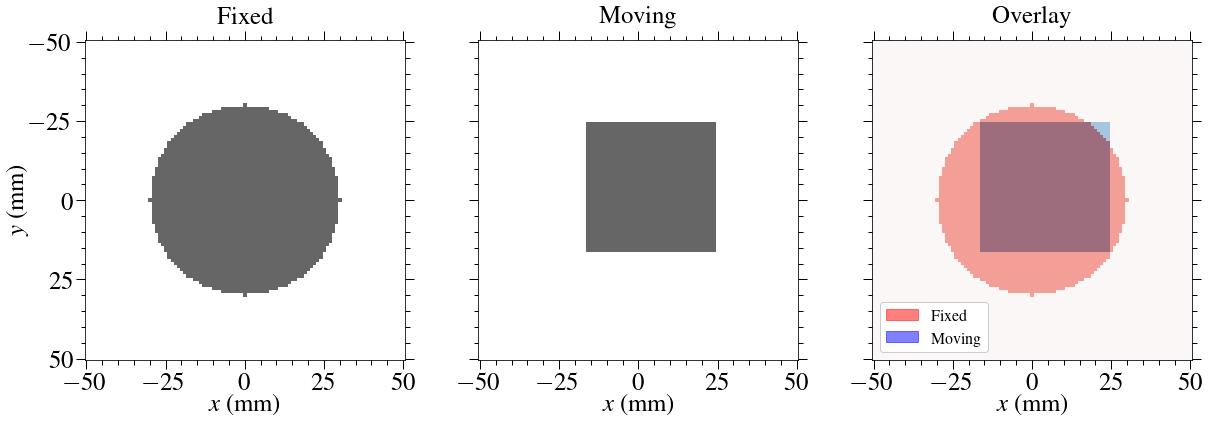

In [5]:
# Display initial images.
reg.view_init(overlay_legend=True, **options)

### 5. Display registration result

The (unaltered) fixed image and transformed moving image are displayed and compared.

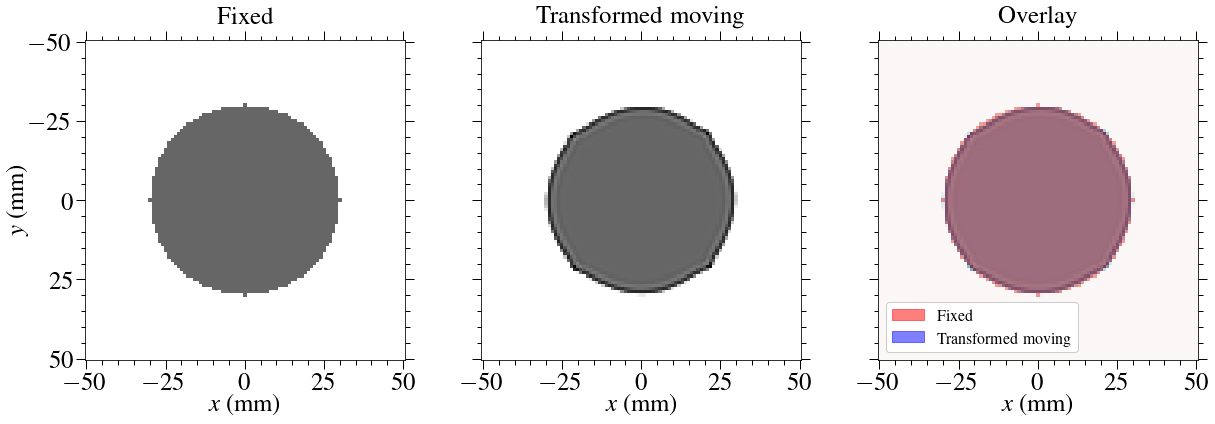

In [6]:
reg.view_result(overlay_legend=True, **options)

### 6. Transformed grid

The moving image and an initially regular grid are displayed after application of the transform calculated at each step in the registration.  This show the effect of pulling grid points from the space of the moving image to the space of the fixed image.

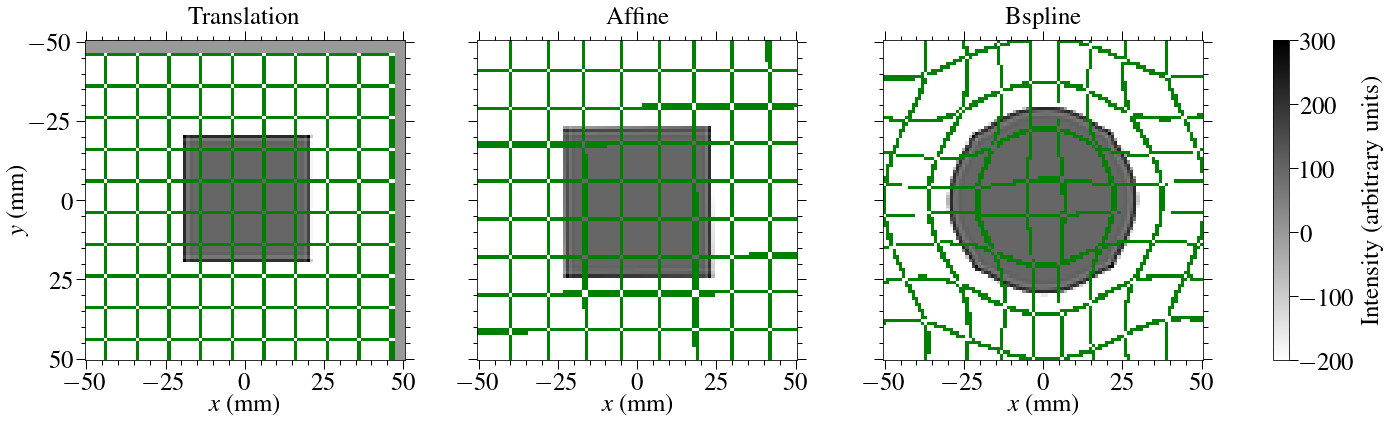

In [7]:
reg.transformed_images[reg.steps[0]].view(
    images=[reg.transformed_images[step] for step in reg.steps[1:]],
    grid=[reg.get_transformed_grid(step) for step in reg.steps],
    title=[step.capitalize() for step in reg.steps],
    colorbar=1, colorbar_label="Intensity (arbitrary units)", figsize=(21, 6), **options)

### 7. Display Jacobian determinant

The registration's Jacobian determinant shows how volumes change locally in mapping from the *fixed* image to the *moving* image.  Positive values define a scaling factor: values greater than 1 indicate expansion; values less than 1 indicate contraction.  Negative values indicate folding.

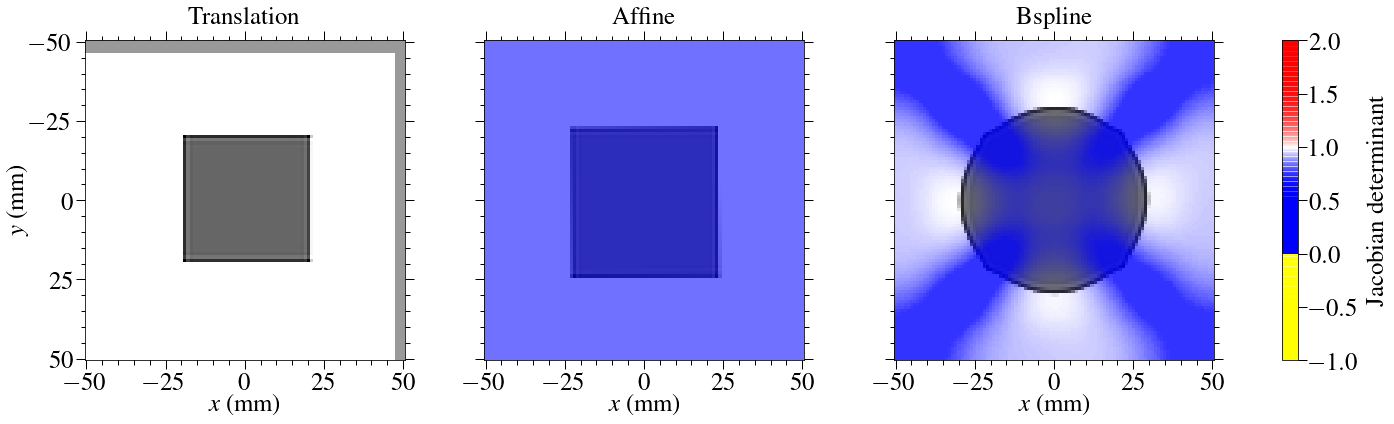

In [8]:
# For axes, set spacing (pad) and size of label and title
reg.transformed_images[reg.steps[0]].view(
    images=[reg.transformed_images[step] for step in reg.steps[1:]],
    jacobian=[reg.get_jacobian(step) for step in reg.steps],
    title=[step.capitalize() for step in reg.steps],
    colorbar=-1, figsize=(21, 6), **options)

### 8. Display information from deformation field

The registration's deformation field is represented by a four-dimensional array.  For each voxel in the (three-dimensional) fixed image, this defines a (three-component) vector defining the displacement in mapping from the *fixed* image to the *moving* image.

#### 8.1 Maximum displacements

In a translation step, maximum displacements reflect offsets of image features in the moving image relative to the corresponding features in the fixed image.  In affine and b-spline steps, maximum displacements can relate to volume changes or shape changes.

In [9]:
form = ".2f"
print(f"Original offsets of sphere centroid relative to cube centroid: dx = {dx:{form}}, dy = {dy:{form}}, dz = {dz:{form}}")
for step in reg.steps:
    displacements = {}
    for xyz in ["x", "y", "z"]:
        displacements[xyz] = reg.get_deformation_field(step).get_displacement_image(xyz).get_data().max()
    print(f"{step}: dx = {displacements['x']:{form}}, dy = {displacements['y']:{form}}, dz = {displacements['z']:{form}}")

Original offsets of sphere centroid relative to cube centroid: dx = 4.00, dy = -4.00, dz = 2.00
translation: dx = 3.28, dy = -3.55, dz = 1.82
affine: dx = 12.87, dy = 5.10, dz = 12.12
bspline: dx = 19.58, dy = 11.25, dz = 17.62


#### 8.2 Quiver plots

Quiver plots show the two-dimensional displacements, in the slice and orientation viewed, for mapping points from the fixed image to the moving image.  Arrow lengths and (by default) colours represent displacement magnitudes.

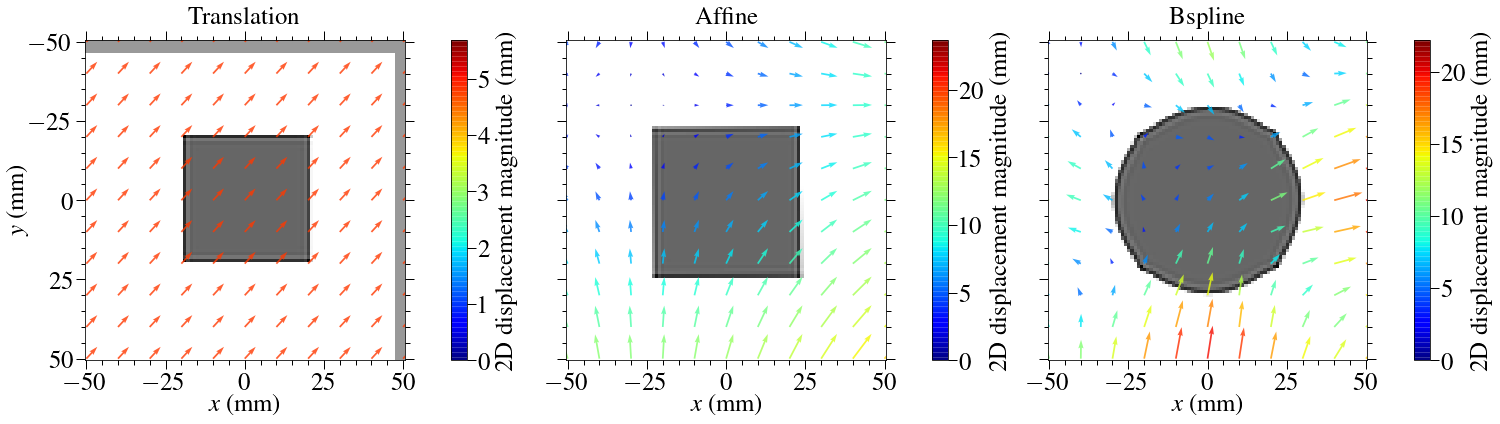

In [10]:
reg.transformed_images[reg.steps[0]].view(
    images=[reg.transformed_images[step] for step in reg.steps[1:]],
    df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
    title=[step.capitalize() for step in reg.steps], df_plot_type="quiver", df_opacity=0.8,
    colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options)

#### 8.3 Deformation grid

The deformation grid at each step in the registration shows how points on a grid in the space of the fixed image are pushed to the moving image.  This means that it shows the effect of transformations in the direction opposite from the transformed grid (section 6 above).

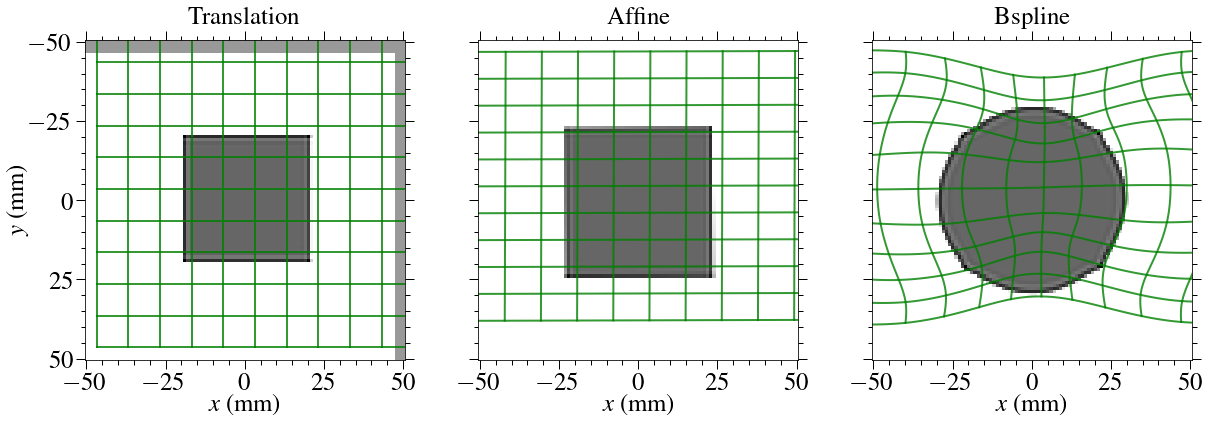

In [11]:
reg.transformed_images[reg.steps[0]].view(
    images=[reg.transformed_images[step] for step in reg.steps[1:]],
    df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
    title=[step.capitalize() for step in reg.steps], df_plot_type="grid", df_opacity=0.8,
    colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options)

#### 8.4 One-dimensional displacements

A plot of one-dimensional displacements shows the displacements along the `x`, `y`, or `z` axis in mapping from fixed image to moving image.

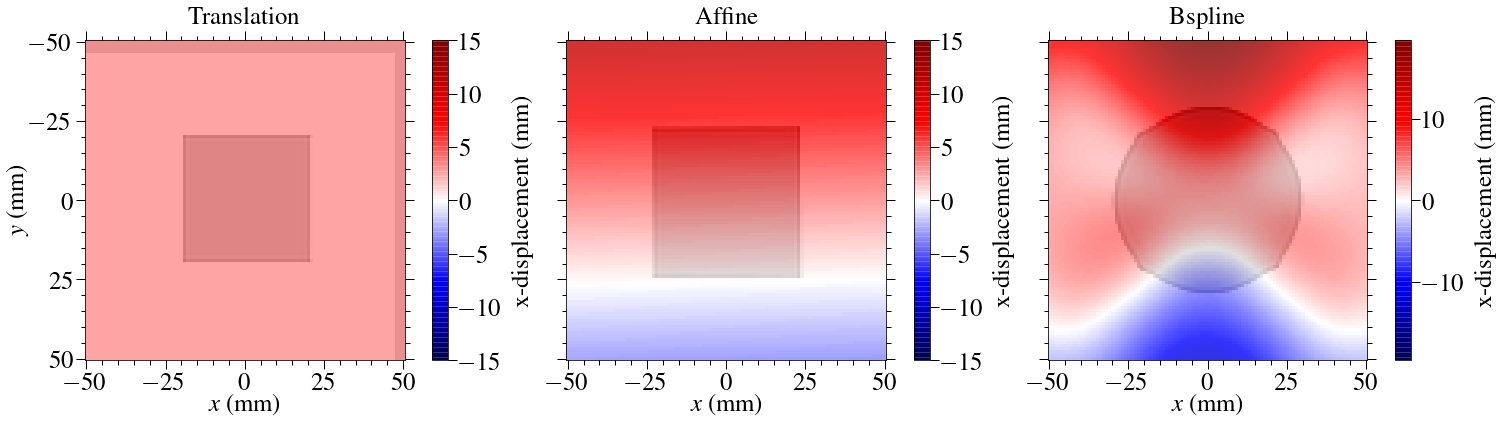

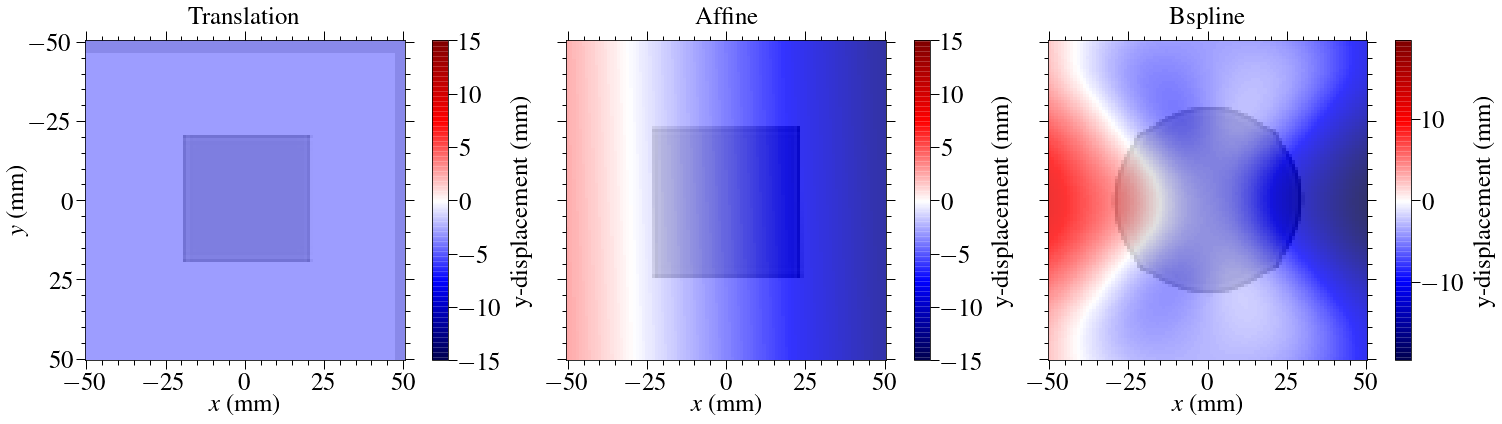

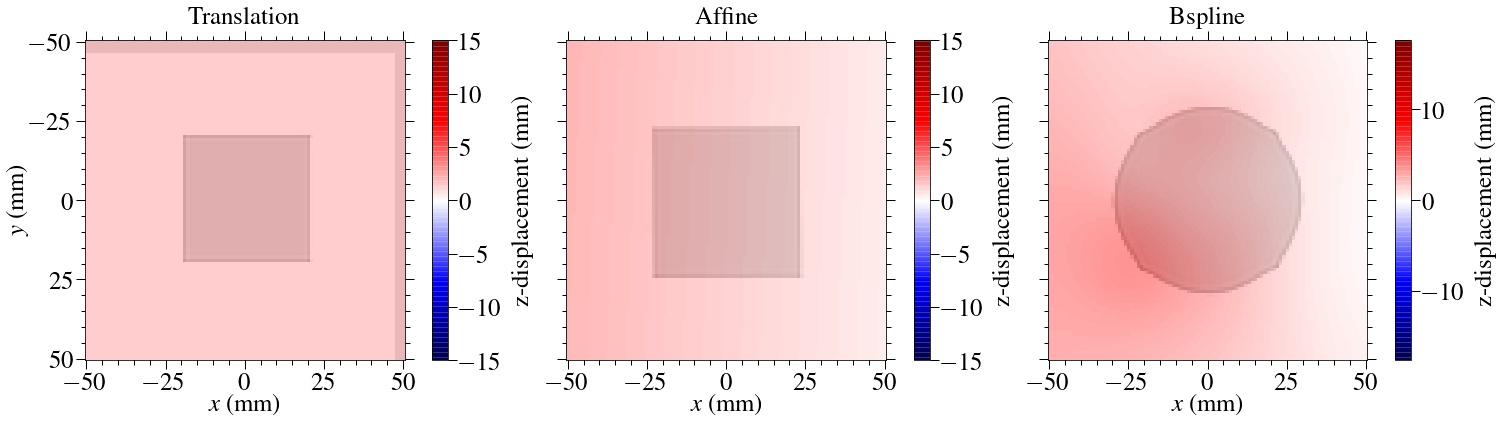

In [12]:
options["clb_kwargs"] = {"pad": 0.05}

for xyz in ["x", "y", "z"]:
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
        title=[step.capitalize() for step in reg.steps], df_plot_type=f"{xyz}-displacement", df_opacity=0.8,
        colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options)

#### 8.5 Three-dimensional displacement magnitudes

A plot of three-dimensional displacement magnituds shows the magnitudes of the three-dimensional displacement vectors for the registration's mapping from fixed image to moving image.

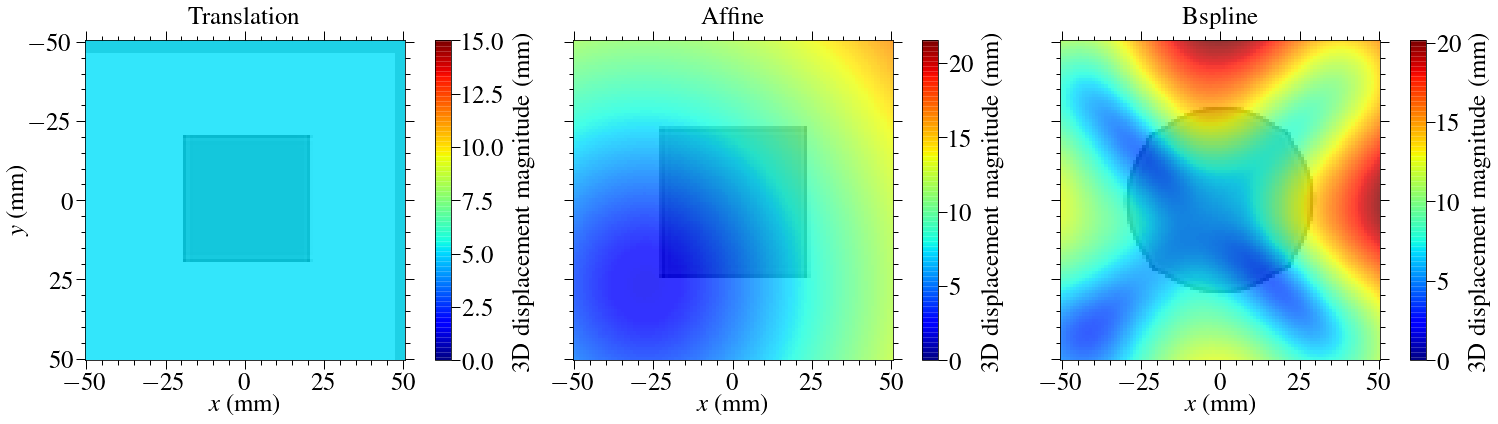

In [13]:
reg.transformed_images[reg.steps[0]].view(
    images=[reg.transformed_images[step] for step in reg.steps[1:]],
    df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
    title=[step.capitalize() for step in reg.steps], df_plot_type="3d-displacement", df_opacity=0.8,
    colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options, df_kwargs={"vmin": 0, "cmap": "jet"})